# Uitwerkingen H7: F7.4

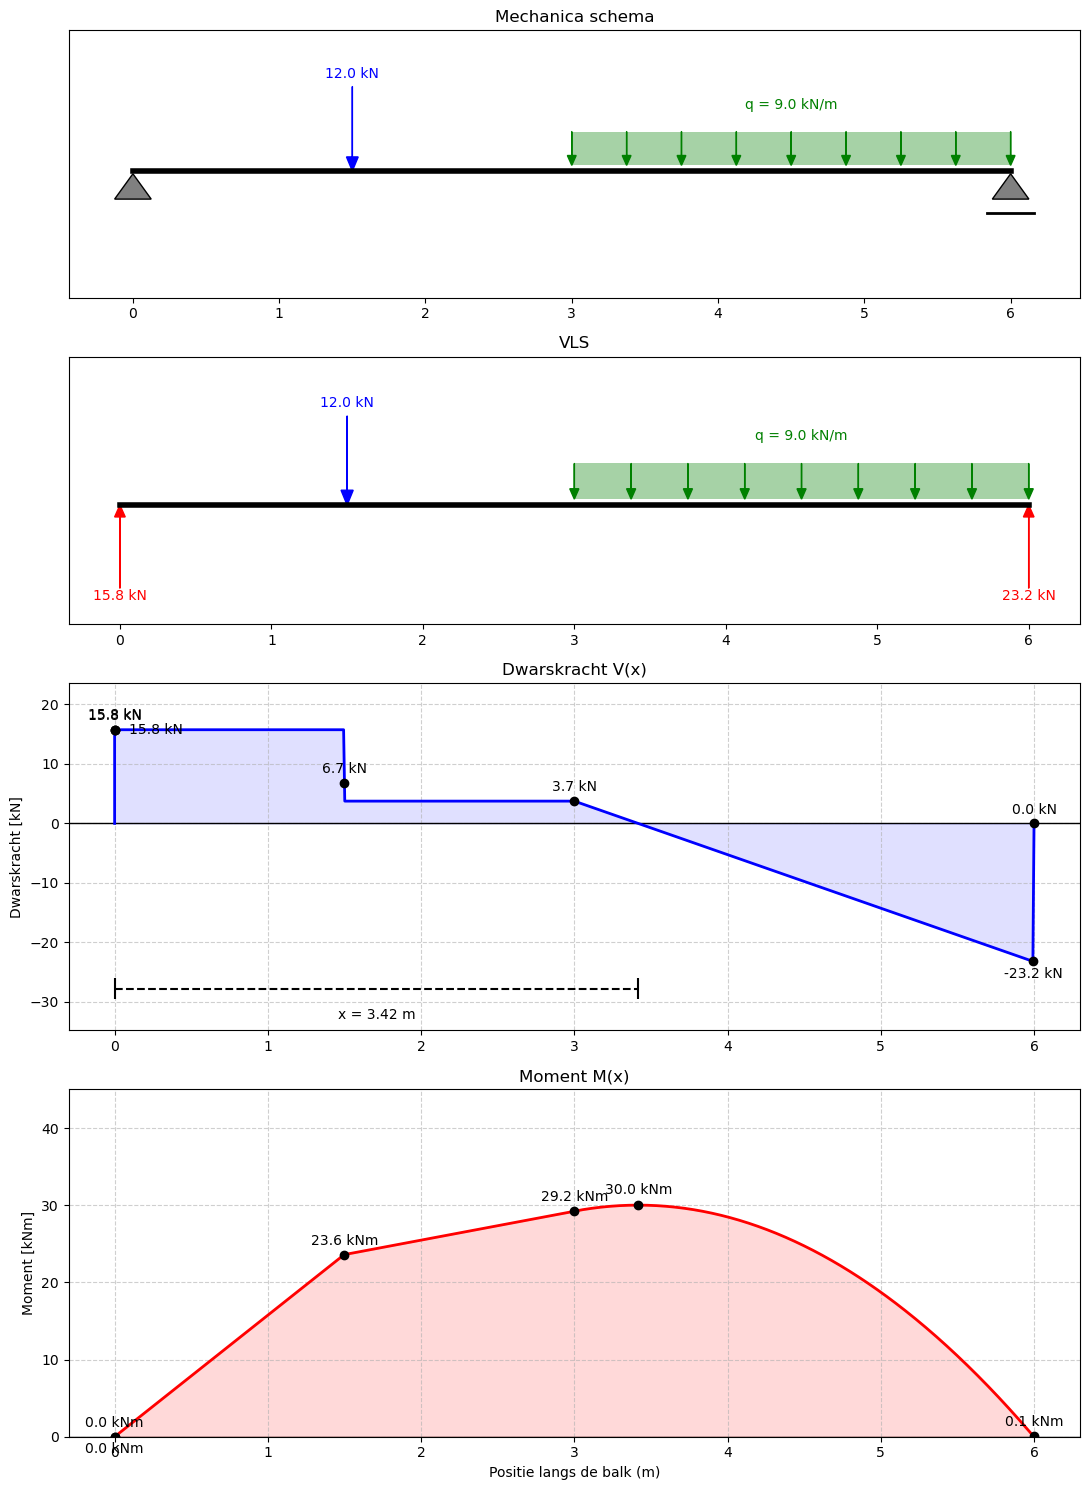

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Arc

# ========================
# PARAMETER-SETUP
# ========================

L = 6        # totale balklengte [m]

# Opleggingen
xA = 6.0          # positie oplegging A (rol) [m]
xB = 0.0          # positie oplegging B (scharnier) [m]

# Verdeelde belasting q (naar beneden, positief) op [q_start, q_end]
q = 9.0           # [kN/m] (0 = geen verdeelde belasting)
q_start = 3.0     # [m]
q_end = 6.0       # [m]

# Puntlast P (naar beneden, positief)
P = 12.0          # [kN] (0 = geen puntlast)
xP = 1.5          # [m]

# Koppel M_C (positief = linksom / CCW)
M_C = 0           # [kNm] (0 = geen koppel)
xC = 5.0          # [m]

# Discretisatie langs de balk
n_points = 800
x = np.linspace(0, L, n_points)
ticks = np.arange(0, L + 1, 1)

# ========================
# REACTIES R_A en R_B
# ========================

# Resultante verdeelde belasting (alleen als q-segment geldig is)
if q != 0 and q_end > q_start:
    Q = q * (q_end - q_start)                     # totale kracht [kN]
    x_qc = 0.5 * (q_start + q_end)                # zwaartepunt [m]
else:
    Q = 0.0
    x_qc = 0.0

# Evenwicht:
#  ∑Fv = 0:   R_A + R_B = Q + P
#  ∑M_A = 0:  R_B*(xB - xA) - Q*(x_qc - xA) - P*(xP - xA) + M_C = 0
# => R_B = (Q*(x_qc - xA) + P*(xP - xA) - M_C) / (xB - xA)
denom = xB - xA
if abs(denom) < 1e-9:
    raise ValueError("xA en xB mogen niet gelijk zijn (opleggingen op dezelfde plaats).")

R_B = (Q * (x_qc - xA) + P * (xP - xA) - M_C) / denom
R_A = Q + P - R_B

# ========================
# DWARSKRACHT V(x)
# ========================

V = np.zeros_like(x)

for i, xi in enumerate(x):
    v = 0.0

    # Rechter-kant van oplegging A
    if xi >= xA:
        v += R_A
    # Rechter-kant van oplegging B
    if xi >= xB:
        v += R_B
    # Verdeelde belasting
    if q != 0 and q_end > q_start and xi > q_start:
        l_q = max(0.0, min(xi, q_end) - q_start)  # lengte van q-segment links van xi
        v -= q * l_q
    # Puntlast
    if P != 0 and xi >= xP:
        v -= P

    V[i] = v

# Maak V-plot ook gesloten naar 0 aan uiteinden
xV = np.concatenate(([0], x, [L]))
V_plot = np.concatenate(([0], V, [0]))

# Extremale waarden
iVmax = np.argmax(V)
iVmin = np.argmin(V)
xVmax, Vmax = x[iVmax], V[iVmax]
xVmin, Vmin = x[iVmin], V[iVmin]

V0 = V[0]   # dwarskracht bij x=0 (kan ≠ R_A als xA ≠ 0)

# Nuldoorgang (eerste x waar V het teken wisselt, benadering)
x_V0 = None
for i in range(1, len(x)):
    if V[i-1] * V[i] < 0:
        # lineaire interpolatie tussen i-1 en i
        t = -V[i-1] / (V[i] - V[i-1])
        x_V0 = x[i-1] + t * (x[i] - x[i-1])
        break

# ========================
# MOMENT M(x) (via integratie van V)
# ========================

M = np.zeros_like(x)
for i in range(1, len(x)):
    dx = x[i] - x[i-1]
    M[i] = M[i-1] + 0.5 * (V[i-1] + V[i]) * dx

# Effect van extern koppel: sprong in M van grootte M_C vanaf xC
if M_C != 0:
    for i, xi in enumerate(x):
        if xi >= xC:
            M[i] -= M_C    # tekenconventie: positief M_C reduceert M rechts

xM = np.concatenate(([0], x, [L]))
M_plot = np.concatenate(([0], M, [0]))

iMmax = np.argmax(M)
iMmin = np.argmin(M)
xMmax, Mmax = x[iMmax], M[iMmax]
xMmin, Mmin = x[iMmin], M[iMmin]

# ========================
# FIGUUR & SUBPLOTS (4 stuks)
# ========================
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    4, 1,
    figsize=(11, 15),
    gridspec_kw={'height_ratios': [1.0, 1.0, 1.3, 1.3]}
)

# Gemeenschappelijke styling voor belastingblok/pijlen
blok_y0 = 0.02
blok_hoogte = 0.12
pijl_start_y = 0.14
pijl_dy = -0.12
aantal_pijlen = 9

# Driehoeken opleggingen
tri_half = 0.125
tri_base_y = -0.10
tri_apex_y = -0.01
rol_line_y = tri_base_y - 0.05
rol_line_halfwidth = 0.16

# =====================================================
# 0. MECHANICA SCHEMA
# =====================================================

# Balk
ax0.plot([0, L], [0, 0], color="black", linewidth=4)

# Verdeelde belasting (alleen op [q_start, q_end])
if q != 0 and q_end > q_start:
    belasting0 = Rectangle((q_start, blok_y0),
                           q_end - q_start, blok_hoogte,
                           facecolor="green", alpha=0.35)
    ax0.add_patch(belasting0)

    for xi in np.linspace(q_start, q_end, aantal_pijlen):
        ax0.arrow(
            xi, pijl_start_y,
            0, pijl_dy,
            head_width=0.06,
            head_length=0.035,
            color="green",
            length_includes_head=True
        )

    ax0.text((q_start + q_end) / 2, blok_y0 + blok_hoogte + 0.08,
             f"q = {q:.1f} kN/m", ha="center", color="green")

# Puntlast tekenen (omlaag)
if P != 0:
    ax0.arrow(
        xP, 0.30,
        0, -0.30,
        head_width=0.08,
        head_length=0.05,
        color="blue",
        length_includes_head=True
    )
    ax0.text(xP, 0.33, f"{P:.1f} kN", ha="center", color="blue")

# Koppel (als boog + pijlpunt)
if M_C != 0:
    radius = 0.35
    arc = Arc((xC, 0.0), radius, radius,
              theta1=40, theta2=320,
              edgecolor="purple", linewidth=2)
    ax0.add_patch(arc)
    # pijltje
    ax0.arrow(
        xC + radius/2, 0.0,
        -0.01, 0.10,
        head_width=0.06,
        head_length=0.04,
        color="purple",
        length_includes_head=True
    )
    ax0.text(xC, -0.18, f"M = {M_C:.1f} kNm",
             ha="center", color="purple")

# Roloplegging op xA (driehoek + streep)
rol_tri = Polygon(
    [[xA - tri_half, tri_base_y],
     [xA + tri_half, tri_base_y],
     [xA,           tri_apex_y]],
    closed=True, facecolor="gray", edgecolor="black"
)
ax0.add_patch(rol_tri)
ax0.plot(
    [xA - rol_line_halfwidth, xA + rol_line_halfwidth],
    [rol_line_y, rol_line_y],
    color="black", linewidth=2
)

# Scharnieroplegging op xB (alleen driehoek)
sch_tri = Polygon(
    [[xB - tri_half, tri_base_y],
     [xB + tri_half, tri_base_y],
     [xB,           tri_apex_y]],
    closed=True, facecolor="gray", edgecolor="black"
)
ax0.add_patch(sch_tri)

ax0.set_ylim(-0.45, 0.5)
ax0.set_yticks([])
ax0.set_title("Mechanica schema")
ax0.set_xticks(ticks)
ax0.set_xticklabels(ticks)
ax0.grid(False)

# =====================================================
# 1. VLS (met reactiekrachten)
# =====================================================

ax1.plot([0, L], [0, 0], color="black", linewidth=4)

# Zelfde verdeelde belasting
if q != 0 and q_end > q_start:
    belasting1 = Rectangle((q_start, blok_y0),
                           q_end - q_start, blok_hoogte,
                           facecolor="green", alpha=0.35)
    ax1.add_patch(belasting1)

    for xi in np.linspace(q_start, q_end, aantal_pijlen):
        ax1.arrow(
            xi, pijl_start_y,
            0, pijl_dy,
            head_width=0.06,
            head_length=0.035,
            color="green",
            length_includes_head=True
        )

    ax1.text((q_start + q_end) / 2, blok_y0 + blok_hoogte + 0.08,
             f"q = {q:.1f} kN/m", ha="center", color="green")

# Puntlast
if P != 0:
    ax1.arrow(
        xP, 0.30,
        0, -0.30,
        head_width=0.08,
        head_length=0.05,
        color="blue",
        length_includes_head=True
    )
    ax1.text(xP, 0.33, f"{P:.1f} kN", ha="center", color="blue")

# Koppel
if M_C != 0:
    radius = 0.35
    arc = Arc((xC, 0.0), radius, radius,
              theta1=40, theta2=320,
              edgecolor="purple", linewidth=2)
    ax1.add_patch(arc)
    ax1.arrow(
        xC + radius/2, 0.0,
        -0.01, 0.10,
        head_width=0.06,
        head_length=0.04,
        color="purple",
        length_includes_head=True
    )
    ax1.text(xC, -0.18, f"{M_C:.1f} kNm",
             ha="center", color="purple")

# Reactiekrachten R_A, R_B
for xpos, R in [(xA, R_A), (xB, R_B)]:
    ax1.arrow(
        xpos, -0.28, 0, 0.28,
        head_width=0.07,
        head_length=0.04,
        color="red",
        length_includes_head=True
    )
    ax1.text(xpos, -0.32, f"{R:.1f} kN",
             ha="center", color="red")

ax1.set_ylim(-0.4, 0.5)
ax1.set_yticks([])
ax1.set_title("VLS")
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks)
ax1.grid(False)

# =====================================================
# 2. DWARSKRACHT V(x)
# =====================================================

ax2.axhline(0, color="black", linewidth=1)
ax2.plot(xV, V_plot, color="blue", linewidth=2)
ax2.fill_between(xV, V_plot, 0, color="blue", alpha=0.12)

ymin_V = 1.5 * V_plot.min()
ymax_V = 1.5 * V_plot.max()
ax2.set_ylim(ymin_V, ymax_V)

# V(0)
ax2.plot(0, V0, "ko")
ax2.annotate(
    f"{V0:.1f} kN",
    (0, V0),
    xytext=(10, 0),
    textcoords="offset points",
    ha="left",
    va="center"
)

# Nuldoorgang (als gevonden)
if x_V0 is not None:
    y_dim = ymin_V + 0.12 * (ymax_V - ymin_V)
    tick_h = 0.03 * (ymax_V - ymin_V)

    ax2.hlines(y_dim, 0, x_V0, colors="black", linestyles="dashed")
    ax2.vlines([0, x_V0], y_dim - tick_h, y_dim + tick_h, colors="black")
    ax2.annotate(
        f"x = {x_V0:.2f} m",
        (x_V0 / 2, y_dim),
        xytext=(0, -14),
        textcoords="offset points",
        ha="center",
        va="top"
    )

# max/min
ax2.plot(xVmax, Vmax, "ko")
ax2.annotate(
    f"{Vmax:.1f} kN",
    (xVmax, Vmax),
    xytext=(0, 8),
    textcoords="offset points",
    ha="center"
)

ax2.plot(xVmin, Vmin, "ko")
ax2.annotate(
    f"{Vmin:.1f} kN",
    (xVmin, Vmin),
    xytext=(0, -12),
    textcoords="offset points",
    ha="center"
)

# ⭐ Nieuw: waarden bij ELKE sprong/verandering in V
event_positions_V = []

for xp in [xA, xB, q_start, q_end, xP]:
    if 0 <= xp <= L:
        event_positions_V.append(xp)

# uniek en gesorteerd
event_positions_V = sorted(set(event_positions_V))

for xp in event_positions_V:
    Vp = np.interp(xp, x, V)
    ax2.plot(xp, Vp, "ko")
    dy = 10 if Vp >= 0 else -14  # label boven of onder de lijn
    ax2.annotate(
        f"{Vp:.1f} kN",
        (xp, Vp),
        xytext=(0, dy),
        textcoords="offset points",
        ha="center",
        va="center"
    )

ax2.set_ylabel("Dwarskracht [kN]")
ax2.set_title("Dwarskracht V(x)")
ax2.set_xticks(ticks)
ax2.set_xticklabels(ticks)
ax2.grid(True, linestyle="--", alpha=0.6)

# =====================================================
# 3. MOMENT M(x)
# =====================================================

ax3.axhline(0, color="black", linewidth=1)
ax3.plot(xM, M_plot, color="red", linewidth=2)
ax3.fill_between(xM, M_plot, 0, color="red", alpha=0.15)

ymin_M = 1.5 * M_plot.min()
ymax_M = 1.5 * M_plot.max()
ax3.set_ylim(ymin_M, ymax_M)

ax3.plot(xMmax, Mmax, "ko")
ax3.annotate(
    f"{Mmax:.1f} kNm",
    (xMmax, Mmax),
    xytext=(0, 8),
    textcoords="offset points",
    ha="center"
)

ax3.plot(xMmin, Mmin, "ko")
ax3.annotate(
    f"{Mmin:.1f} kNm",
    (xMmin, Mmin),
    xytext=(0, -12),
    textcoords="offset points",
    ha="center"
)

# ⭐ Nieuw: waarden bij ELKE sprong/verandering in M
event_positions_M = []

for xp in [xA, xB, q_start, q_end, xP]:
    if 0 <= xp <= L:
        event_positions_M.append(xp)
if M_C != 0 and 0 <= xC <= L:
    event_positions_M.append(xC)

event_positions_M = sorted(set(event_positions_M))

for xp in event_positions_M:
    Mp = np.interp(xp, x, M)
    ax3.plot(xp, Mp, "ko")
    dy = 10 if Mp >= 0 else -14
    ax3.annotate(
        f"{Mp:.1f} kNm",
        (xp, Mp),
        xytext=(0, dy),
        textcoords="offset points",
        ha="center",
        va="center"
    )

ax3.set_xlabel("Positie langs de balk (m)")
ax3.set_ylabel("Moment [kNm]")
ax3.set_title("Moment M(x)")
ax3.set_xticks(ticks)
ax3.set_xticklabels(ticks)
ax3.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
